# Berg - Pre- and Post-processing

**To do:**
- Check if order of GSD classes is preserved while doing the back calculation
- Check strange occurence of ca. 85% for z_1000 in GZ layer
- Check method overall

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA
import os
import re
import xarray

In [3]:
def pre_processing(file, save_data=False, save_name=None):
    
    # -------------------------
    # DATA LOADING AND CLEANING
    # -------------------------
    
    xlsx_file = pd.ExcelFile(file)
    print(xlsx_file.sheet_names)
    
    # Create dictionary of geological layer dataframes 
    df_dict = {}

    for sheet_name in xlsx_file.sheet_names:
        df_dict[sheet_name] = xlsx_file.parse(sheet_name)
        
    
    # Drop rows with no or incomplete GSD's
    for key, value in df_dict.items():
        df_dict[key] = value.dropna(subset=["z_90"])

    # Set hole_id as index
    for key, value in df_dict.items():
        df_dict[key] = value.set_index("hole_id")
        
    # Drop unnecessary columns
    df_dict_GSD = {}

    for key, value in df_dict.items():
        df_dict_GSD[key] = value.loc[:, df_dict[key].columns[9:19]]
    
    # Replace zero by very small value
    for key, value in df_dict_GSD.items():
        df_dict_GSD[key] = value.replace(0, 0.000001)
    
    # Correct percentages so they sum up to exactly 100
    for key, value in df_dict_GSD.items():
        df_dict_GSD[key] = value.divide(value.sum(axis=1), axis=0) * 100
    
    
    # ------------------
    # CLR TRANSFORMATION
    # ------------------
    
    df_dict_GSD_ln = {}

    for key, value in df_dict_GSD.items():
        df_dict_GSD_ln[key] = np.log(value)
        
    df_dict_GSD_clr = {}

    for key, value in df_dict_GSD_ln.items():
        df_dict_GSD_clr[key] = value.subtract(value.mean(axis=1), axis=0)
    
    
    # -----------------------------------
    # PRINCINPAL COMPONENT ANALYSIS (PCA)
    # -----------------------------------
    
    dict_pca = {}
    df_dict_variance = {}

    for key, value in df_dict_GSD_clr.items():

        data = value

        pca = PCA(n_components = 10)
        pca.fit(data)

        dict_pca[key] = pca
        df_dict_variance[key] = pca.explained_variance_ratio_

        print(np.sum(pca.explained_variance_ratio_[0:4]))
    
    df_dict_pca = {}

    for key, value in dict_pca.items():
        df_dict_pca[key] = pd.DataFrame(value.transform(df_dict_GSD_clr[key]), 
                                        columns=["PC" + "{:02}".format(i) for i in range(1,11)], 
                                        index=df_dict_GSD_clr[key].index)
    
    df_dict_pca_merge = {}

    for key, value in df_dict_pca.items():
        df_dict_pca_merge[key] = pd.merge(df_dict["GZ"][["lat", "lon"]], 
                                          value, 
                                          left_index=True, 
                                          right_index=True)
    
    df_variance = pd.DataFrame.from_dict(df_dict_variance).T
    df_variance.columns = ["PC" + "{:02}".format(i) for i in range(1,11)]
    
    
    # ---------
    # SAVE DATA
    # ---------
    
    if save_data == True:
        if save_name != None:
            writer = pd.ExcelWriter("../_RESULTS/" + save_name + ".xlsx")
        else:
            writer = pd.ExcelWriter("../_RESULTS/Berg_pca.xlsx")

        for key, value in df_dict_pca_merge.items():
            value.to_excel(writer, key)

        df_variance.to_excel(writer, "pca_variance")
        writer.close()

    return [df_dict_GSD_clr, dict_pca, df_dict_pca_merge, df_variance]

In [4]:
Berg_preprocessed_results = pre_processing("../_DATA/Berg_usable_data.xlsx", save_data=True, save_name="Berg_usable_data_pca");

['TZ', 'IZ', 'GZ']
0.963207444201
0.977733320157
0.985948182204


In [5]:
MHZ_preprocessed_results = pre_processing("../_DATA/MHZ_usable_data.xlsx", save_data=True, save_name="MHZ_usable_data_pca");

['TZ', 'IZ', 'GZ']
0.98948928925
0.990465715157
0.986404984465


In [2]:
file = "../_RESULTS/Berg_processed_individual.xlsx"

# df_OVB = pd.read_excel(file, sheet_name="OVB")
# df_TZ = pd.read_excel(file, sheet_name="TZ")
# df_BC = pd.read_excel(file, sheet_name="BC")
# df_IZ = pd.read_excel(file, sheet_name="IZ")
# df_GZ = pd.read_excel(file, sheet_name="GZ")

In [3]:
xlsx_file = pd.ExcelFile(file)

In [4]:
xlsx_file.sheet_names

['GZ', 'OVB', 'TZ', 'BC', 'IZ']

In [5]:
# Create dictionary of geological layer dataframes 
df_dict = {}

for sheet_name in xlsx_file.sheet_names:
    df_dict[sheet_name] = xlsx_file.parse(sheet_name)

In [6]:
# Drop rows with no or incomplete GSD's
for key, value in df_dict.items():
    df_dict[key] = value.dropna(subset=["z_90"])

In [7]:
# Set hole_id as index
for key, value in df_dict.items():
    df_dict[key] = value.set_index("hole_id")

In [8]:
set(df_dict["IZ"].index) - set(df_dict["GZ"].index)

{'BRG_16_04A', 'BRG_16_06', 'ECO_09_03'}

In [9]:
set(df_dict["TZ"].index) - set(df_dict["GZ"].index)

{'BRG_16_04A', 'BRG_16_06', 'ECO_09_03'}

In [10]:
set(df_dict["IZ"].index) - set(df_dict["TZ"].index)

{'BRG_05_06', 'BRG_05_07'}

In [11]:
df_dict["OVB"].loc[:, df_dict["OVB"].columns[0:8]].head()

,max_depth,lat,lon,elevation,year,depth_from,depth_to,code_geol
hole_id,,,,,,,,
BRG_01_01,30.0,50.968792,5.629597,72.51,2001,0,0.09,OVB
BRG_01_02,28.0,50.967983,5.628914,74.46,2001,0,0.45,OVB
BRG_01_03,32.0,50.967165,5.628067,76.47,2001,0,2.03,OVB
BRG_01_04,33.0,50.966359,5.628572,77.46,2001,0,0.45,OVB
BRG_01_05,30.0,50.965749,5.628222,75.31,2001,0,0.31,OVB


In [12]:
# Drop unnecessary columns
df_dict_GSD = {}

for key, value in df_dict.items():
    df_dict_GSD[key] = value.loc[:, df_dict[key].columns[9:19]]

In [13]:
# Replace zero by very small value
for key, value in df_dict_GSD.items():
    df_dict_GSD[key] = value.replace(0, 0.000001)

In [14]:
# Correct percentages so they sum up to exactly 100
for key, value in df_dict_GSD.items():
    df_dict_GSD[key] = value.divide(value.sum(axis=1), axis=0) * 100

In [15]:
df_dict_GSD["OVB"].head()

,z_1000,z_710,z_500,z_355,z_250,z_180,z_125,z_90,z_63,z_0
hole_id,,,,,,,,,,
BRG_01_01,1.001001e-06,1.001001e-01,0.5005,4.104104,25.025025,51.551551,15.515515,2.702703,0.500500,1.001001e-06
BRG_01_02,1.000000e-06,1.000000e-06,1.1000,7.100000,27.999999,46.599999,13.600000,2.700000,0.800000,1.000000e-01
BRG_01_03,1.000000e-06,1.000000e-06,0.6000,6.800000,32.599999,46.999999,9.300000,2.400000,1.300000,1.000000e-06
BRG_01_04,1.001001e-06,1.001001e-06,0.5005,4.904905,26.326326,50.050049,13.613613,3.203203,1.401401,1.001001e-06
BRG_01_05,1.000000e-06,1.000000e-06,0.1000,1.000000,23.299999,59.799998,12.800000,2.800000,0.200000,1.000000e-06


In [16]:
df_dict_GSD_ln = {}

for key, value in df_dict_GSD.items():
    df_dict_GSD_ln[key] = np.log(value)

In [17]:
df_dict_GSD_clr = {}

for key, value in df_dict_GSD_ln.items():
    df_dict_GSD_clr[key] = value.subtract(value.mean(axis=1), axis=0)

In [18]:
dict_pca = {}
df_dict_variance = {}

for key, value in df_dict_GSD_clr.items():

    data = value

    pca = PCA(n_components = 10)
    pca.fit(data)
    
    dict_pca[key] = pca
    df_dict_variance[key] = pca.explained_variance_ratio_
    
    print(np.sum(pca.explained_variance_ratio_[0:4]))

0.942183725347
0.977367765518
0.937206042822
0.966763065499
0.936993261297


In [19]:
df_dict_pca = {}

for key, value in dict_pca.items():
    df_dict_pca[key] = pd.DataFrame(value.transform(df_dict_GSD_clr[key]), 
                                    columns=["PC" + "{:02}".format(i) for i in range(1,11)], 
                                    index=df_dict_GSD_clr[key].index)

In [20]:
df_dict_pca_merge = {}

for key, value in df_dict_pca.items():
    df_dict_pca_merge[key] = pd.merge(df_dict["GZ"][["lat", "lon"]], 
                                      value, 
                                      left_index=True, 
                                      right_index=True)

In [21]:
df_dict_pca_merge["GZ"].head()

,lat,lon,PC01,PC02,PC03,PC04,PC05,PC06,PC07,PC08,PC09,PC10
hole_id,,,,,,,,,,,,
BRG_01_01,50.968792,5.629597,9.796987,-2.186659,-1.067774,0.860946,6.166735,-0.336942,0.120499,0.220154,-0.010144,8.326673e-16
BRG_01_02,50.967983,5.628914,7.250301,-3.029925,7.002011,-2.703135,0.323428,0.098304,-0.199613,-0.135678,0.082046,-1.776357e-15
BRG_01_03,50.967165,5.628067,7.166600,-3.026135,6.538940,-2.531529,0.658935,-0.264978,0.301931,-0.309205,-0.098430,-1.554312e-15
BRG_01_04,50.966359,5.628572,6.810487,-2.659585,6.376077,-2.666042,0.171537,-0.772684,0.815802,0.392803,-0.049010,4.440892e-16
BRG_01_05,50.965749,5.628222,9.959967,4.852496,-4.211809,-0.524939,-1.153949,-0.740445,-0.226628,0.171941,0.132215,0.000000e+00


In [22]:
df_variance = pd.DataFrame.from_dict(df_dict_variance).T
df_variance.columns = ["PC" + str(i) for i in range(1,11)]
df_variance

,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,PC10
BC,0.471244,0.318851,0.109607,0.067060,0.025422,0.004805,0.002131,0.000785,0.000093,2.933555e-33
GZ,0.519350,0.202993,0.146226,0.073616,0.048155,0.006643,0.002499,0.000419,0.000100,3.041698e-32
IZ,0.546605,0.258659,0.067640,0.064089,0.046152,0.010795,0.005113,0.000800,0.000146,2.229165e-32
OVB,0.590431,0.203146,0.139193,0.044599,0.015653,0.003946,0.002560,0.000374,0.000100,8.624043e-33
TZ,0.563482,0.203493,0.094738,0.075492,0.037932,0.019250,0.004326,0.001140,0.000146,7.066267e-33


In [23]:
writer = pd.ExcelWriter("../_RESULTS/Berg_pca.xlsx")

for key, value in df_dict_pca_merge.items():
    value.to_excel(writer, key)

df_variance.to_excel(writer, "pca_variance")
writer.close()

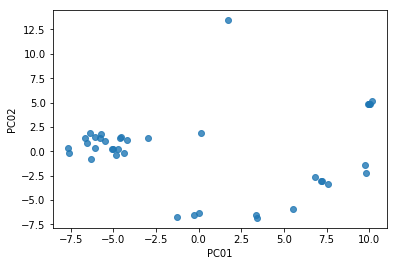

In [24]:
sns.regplot("PC01", "PC02", data=df_dict_pca["GZ"], fit_reg=False)
plt.show()

In [14]:
def intr_dim(df, n_comp=None, bar=True, cumul=True):
    """Plot variance ratio of PCA to determine intrinsic dimension
    
    Parameters:
    -----------
    df : pd.DataFrame
        Data to use for PCA
    n_comp : int (optional)
        Number of components to use in PCA (defaults to None)
    bar : Bool (optional)
        Whether to generate barplot (defaults to True)
    cumul : Bool (optional)
        Whether to generate cumulative plot (defaults to True)
        
    Returns:
    --------
    None
    
    """
    
    # Create pca model
    model_check = PCA(n_components=n_comp)
    
    # FIt pca model
    model_check.fit(df)
    features = range(model_check.n_components_)
    
    # Plot variance ratio per principal component
    fig, ax1 = plt.subplots(nrows=1, sharex=True, sharey=True, figsize=(8,4))
    
    # Barplot
    if bar :
        rects = ax1.bar(features, model_check.explained_variance_ratio_)
        ax1.set_ylabel("Variance ratio")
    
    # Cumulative plot
    if cumul :
        y = np.insert(model_check.explained_variance_ratio_.cumsum(), 0, 0)
        ax1.plot(range(0,10), y[1:], linestyle='none', marker='o')
        ax1.set_ylabel("Cumulative variance ratio")
    

    # Title and axes labels
    #plt.suptitle("Variance ratio per principal component")
    plt.xlabel("Dimensions")
    
    def autolabel(rects):
        """Attach a text label above each bar displaying its height
        
        Parameters:
        -----------
        rects : list
            Bars of barplot
            
        Returns:
        --------
        None
        
        """
        
        for rect in rects:
            i = 0
            height = []
            height.append(rect.get_height())
            ax1.text(rect.get_x() + rect.get_width()/2., height[i],
                     '%2.1f' % (float(height[i])*100),
                      ha='center', va='bottom')
            i += 1
        
        return
    
    
    # Labels
    if bar :
        autolabel(rects)
    
    # Hide major tick labels
    ax1.set_xticklabels('')

    # Customize minor tick labels
    ax1.set_xticks(np.arange(0, 10), minor=True)
    ax1.set_xticklabels(['1','2','3','4','5','6','7','8','9','10'], minor=True)
    
    ax1.set_xlim([-0.5, 9.5])
    #ax1.set_ylim([-0.05, 1.05])
    
    # Margins
    #plt.margins(0.02)
    
    plt.hlines(0.95, -0.5, 9.5)
    plt.text(-0.2, 0.965, "0.95 threshold")
    
    plt.show()
    
    return

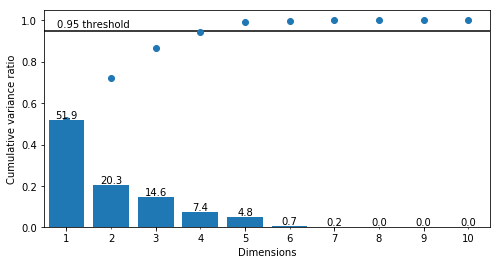

In [21]:
intr_dim(df_dict_GSD_clr["GZ"], n_comp=10, cumul=True, bar=True)

In [27]:
df_dict_GSD_clr[key].head()

,z_1000,z_710,z_500,z_355,z_250,z_180,z_125,z_90,z_63,z_0
hole_id,,,,,,,,,,
BRG_01_01,-8.630379,-8.630379,0.936636,4.625516,8.020862,9.388330,7.905486,3.644686,-8.630379,-8.630379
BRG_01_02,-9.714888,-9.714888,0.411744,3.845731,7.000670,8.265543,6.887946,3.014433,-0.281404,-9.714888
BRG_01_03,-8.794249,-8.794249,2.207850,4.720156,7.714536,9.270042,7.670269,3.594145,-8.794249,-8.794249
BRG_01_04,-1.120799,-10.554283,-1.120799,2.057254,5.860206,7.515776,5.999645,1.651789,0.265495,-10.554283
BRG_01_05,-9.614429,-9.614429,0.799884,3.828406,7.175477,8.431801,6.566120,2.340329,-0.298728,-9.614429


In [28]:
test_clr = np.exp(df_dict_GSD_clr["GZ"])
test_clr.head()

,z_1000,z_710,z_500,z_355,z_250,z_180,z_125,z_90,z_63,z_0
hole_id,,,,,,,,,,
BRG_01_01,0.000127,0.000127,12.721541,292.595450,4325.324040,6977.765401,1068.609469,31.803853,0.000127,0.000127
BRG_01_02,0.000039,0.000039,3.911282,62.580518,790.079034,2456.285314,574.958505,15.645129,3.911282,0.000039
BRG_01_03,0.000046,0.000046,4.638495,55.661937,1092.365510,2906.016951,568.215605,9.276989,2.319247,0.000046
BRG_01_04,0.000058,0.000058,2.903562,37.746307,1997.650687,3490.081578,264.224146,8.710686,2.903562,0.000058
BRG_01_05,0.000528,0.000528,0.000528,448.600962,24831.382658,25807.749458,1609.685805,52.776584,0.000528,0.000528


In [29]:
test = test_clr.divide(test_clr.sum(axis=1), axis=0) * 100
test.head()

,z_1000,z_710,z_500,z_355,z_250,z_180,z_125,z_90,z_63,z_0
hole_id,,,,,,,,,,
BRG_01_01,1.001001e-06,1.001001e-06,0.100100,2.302302,34.034033,54.904903,8.408408,0.250250,0.000001,1.001001e-06
BRG_01_02,1.001001e-06,1.001001e-06,0.100100,1.601602,20.220220,62.862861,14.714714,0.400400,0.100100,1.001001e-06
BRG_01_03,1.000000e-06,1.000000e-06,0.100000,1.200000,23.549999,62.649998,12.250000,0.200000,0.050000,1.000000e-06
BRG_01_04,1.000500e-06,1.000500e-06,0.050025,0.650325,34.417208,60.130063,4.552276,0.150075,0.050025,1.000500e-06
BRG_01_05,1.000500e-06,1.000500e-06,0.000001,0.850425,47.073534,48.924460,3.051526,0.100050,0.000001,1.000500e-06


In [30]:
df_dict_GSD[key].head()

,z_1000,z_710,z_500,z_355,z_250,z_180,z_125,z_90,z_63,z_0
hole_id,,,,,,,,,,
BRG_01_01,0.000001,0.000001,0.014296,0.571837,17.055039,66.947817,15.196568,0.214439,0.000001,0.000001
BRG_01_02,0.000001,0.000001,0.025013,0.775388,18.184092,64.419708,16.245622,0.337669,0.012506,0.000001
BRG_01_03,0.000001,0.000001,0.060012,0.740148,14.782956,70.034004,14.142828,0.240048,0.000001,0.000001
BRG_01_04,0.012511,0.000001,0.012511,0.300263,13.461779,70.486674,15.476041,0.200175,0.050044,0.000001
BRG_01_05,0.000001,0.000001,0.033374,0.689732,19.601735,68.850816,10.657470,0.155746,0.011125,0.000001


In [31]:
df_dict_GSD_clr[key].mean()

z_1000   -3.234573
z_710    -4.232087
z_500    -1.845187
z_355     1.102658
z_250     4.375931
z_180     5.641204
z_125     4.366317
z_90      0.861876
z_63     -2.555164
z_0      -4.480975
dtype: float64

___

### Test case 1: First clr transform, then normalize

In [ ]:
# Test data
test_matrix = [[0.2, 0.3, 0.5],
               [0.3, 0.4, 0.3],
               [0.1, 0.3, 0.6],
               [0.25, 0.35, 0.4],
               [0.01, 0.57, 0.42]]

test_df = pd.DataFrame(test_matrix)
test_df

In [ ]:
test_df.mean(axis=0)

In [ ]:
# Logarithm
test_df_ln = np.log(test_df)
test_df_ln

In [ ]:
# Clr transform
test_df_clr = test_df_ln.subtract(test_df_ln.mean(axis=1), axis=0)
test_df_clr

In [ ]:
# Reverse clr transform
np.exp(test_df_clr.mean(axis=0)) / np.sum(np.exp(test_df_clr.mean(axis=0)))

___

### Test case 2: First normalize, then clr transform

In [ ]:
# Test data
test = np.array([0.2, 1/3, 7/15])
test

In [ ]:
# Logarithm
test_ln = np.log(test)
test_ln

In [ ]:
# clr transform
test_clr =  test_ln - test_ln.mean(axis=0)
test_clr

In [ ]:
# Reverse clr transform
np.exp(test_clr) / np.sum(np.exp(test_clr))

___

In [358]:
n_comp = 10
key = "GZ"

# Reconstruct clr data from pca using n_comp components
# PCA reconstruction = PC scores . (Eigenvectors)T + Mean
#https://stats.stackexchange.com/questions/229092/how-to-reverse-pca-and-
#reconstruct-original-variables-from-several-principal-com
X = np.dot(df_dict_pca[key].values[:, :n_comp], dict_pca[key].components_[:n_comp, :])
print(X[:5,])
print(df_dict_GSD_clr[key].mean().values)
X += df_dict_GSD_clr[key].mean().values#axis=1).values[:, np.newaxis]
print(X[:5,])

# Put reconstructed data in dataframe
df_X_clr = pd.DataFrame(X, index=df_dict_GSD_clr[key].index.tolist(), 
                        columns=df_dict_GSD_clr[key].columns.tolist())
print(df_X_clr.head())
# Calculate reconstructed log-ratios
#df_X_ln = df_X_clr.add(df_dict_GSD_ln[key].mean(axis=1), axis=0) 

# Exponentiate to obtain reconstructed ratios
df_X_ratio = np.exp(df_X_clr) / np.sum(np.exp(df_X_clr))

# Mulitply by predicted values to obtain reconstructed observed values
#df_X_recon = df_X_ratio * df_pred

df_X_ratio = df_X_ratio.divide(df_X_ratio.sum(axis=1), axis=0) * 100

df_X_ratio.head()

[[-5.11932476 -3.00732818  4.34162692  3.16389502  3.01907221  2.86605459
   2.38621562  1.9580706  -6.16812449 -3.44015753]
 [-6.29875619 -4.18675961  3.16219549  1.62155809  1.31896286  1.82197604
   1.76639997  1.24864279  4.16536954 -4.61958897]
 [-6.12823158 -4.016235    3.3327201   1.50440064  1.64293069  1.99010926
   1.75460303  0.72602023  3.64274697 -4.44906435]
 [-5.90353603 -3.79153945  2.86426848  1.11599172  2.24655699  2.17325098
   0.98889988  0.66303371  3.86744252 -4.2243688 ]
 [-3.69655388 -1.5845573  -5.74852766  3.59123785  4.76669343  4.17400068
   2.79589638  2.46455075 -4.74535361 -2.01738665]]
[-3.85030398 -5.96230056 -1.7983302   2.51489591  5.35317013  5.98442941
  4.5878979   1.50151685 -2.80150425 -5.52947121]
[[ -8.96962874  -8.96962874   2.54329672   5.67879094   8.37224234
    8.850484     6.97411352   3.45958745  -8.96962874  -8.96962874]
 [-10.14906018 -10.14906018   1.36386529   4.13645401   6.67213298
    7.80640545   6.35429787   2.75015965   1.3638

,z_1000,z_710,z_500,z_355,z_250,z_180,z_125,z_90,z_63,z_0
BRG_01_01,0.002304,0.019689,47.150663,20.310327,6.787211,8.038550,8.158219,9.531201,0.000987,0.000850
BRG_01_02,0.001136,0.009709,23.250223,6.967041,1.988397,4.538371,7.040001,7.519811,48.684892,0.000419
BRG_01_03,0.001639,0.014009,33.549391,7.539927,3.345032,6.533095,8.465430,5.425434,35.125438,0.000604
BRG_01_04,0.002204,0.018838,22.556568,5.491837,6.570314,8.427345,4.228075,5.471597,47.232410,0.000813
BRG_01_05,0.007464,0.063792,0.001528,24.319697,30.431422,23.219887,9.597676,12.352583,0.003199,0.002753


In [359]:
df_dict_GSD[key].head()

,z_1000,z_710,z_500,z_355,z_250,z_180,z_125,z_90,z_63,z_0
hole_id,,,,,,,,,,
BRG_01_01,1.001001e-06,1.001001e-06,0.100100,2.302302,34.034033,54.904903,8.408408,0.250250,0.000001,1.001001e-06
BRG_01_02,1.001001e-06,1.001001e-06,0.100100,1.601602,20.220220,62.862861,14.714714,0.400400,0.100100,1.001001e-06
BRG_01_03,1.000000e-06,1.000000e-06,0.100000,1.200000,23.549999,62.649998,12.250000,0.200000,0.050000,1.000000e-06
BRG_01_04,1.000500e-06,1.000500e-06,0.050025,0.650325,34.417208,60.130063,4.552276,0.150075,0.050025,1.000500e-06
BRG_01_05,1.000500e-06,1.000500e-06,0.000001,0.850425,47.073534,48.924460,3.051526,0.100050,0.000001,1.000500e-06


___

### Iris example

___

## Reverse PCA

**To do**:
- Extend function to handle data of multiple layers
- Add 6 lines of information needed for creation of asci file (save as asci file immediately by using to_text and append functionality?)

In [184]:
for file in os.listdir("../_KRIGING/Berg/PCA/GZ/"):
    if file.endswith(".xlsx"):
        m = regex.search(file)
        print(m.group())

PC01
PC02
PC03
PC04
PC05
PC06
PC07
PC08
PC09
PC10


In [52]:
regex = re.compile("(CONVERTED_[a-zA-Z]+)")
regex.search("../_KRIGING/Converted/CONVERTED_Berg/GZ/")

<_sre.SRE_Match object; span=(22, 36), match='CONVERTED_Berg'>

In [96]:
def post_processing(directory, df_dict_GSD_clr, dict_pca, grid_data, n_components=5):
    
    # ---------
    # LOAD DATA
    # ---------
    
    # Get quarry code information
    regex0 = re.compile("(CONVERTED_[A-Za-z]+)")
    quarry_code = regex0.search(directory).group()
    quarry_code = quarry_code[10:]
    
    
    # Get geological layer code information
    regex1 = re.compile("(/[A-Z][A-Z]/)")
    code_geol = regex1.search(directory).group()
    code_geol = code_geol[1:-1]
    
    print(quarry_code, code_geol)
    
    # Load in PCA component files
    df_dict_pca_kriged = {}
    n_files = 0
    
    # Set up regaular expression to look for PCA component number in filename
    regex2 = re.compile("(PC\d\d)")
    
    # Loop through files
    for file in os.listdir(directory):
        if file.endswith(".xlsx"):
            m = regex2.search(file)
            component = m.group()
            df_dict_pca_kriged[component] = pd.read_excel(directory + "/" + file, header=None)
            print(file, df_dict_pca_kriged[component].shape)
            n_files += 1
    
    panel = pd.Panel(df_dict_pca_kriged)
    
    # Iterate over all values of all dataframes in the panel
    counter = 0
    
    for label, df in panel.iteritems():
        for index, row in df.iterrows():
            for element in row:
                counter += 1
    
    print("Number of grid points per file :", counter/n_files)
    print("Number of grid point in total:", counter)
    
    # Create list of PC scores per kriged gridpoint
    points = []
    
    for i in range(panel.shape[1]):
        for j in range(panel.shape[2]):
            total = []
            for key, value in df_dict_pca_kriged.items():
                total.append(value.loc[i,j])
            points.append(total)
            
    print("gridpoints:", len(points))
    
    
    # -----------
    # REVERSE PCA
    # -----------

    X = []
    n_comp=n_components
    # Set PCA model properties to use
    model = dict_pca[code_geol]

    for total in points:
        x = np.dot(total[:n_comp], model.components_[:n_comp, :])
        X.append(x)
    
    
    # --------------------------
    # REVERSE CLR TRANSFORMATION
    # --------------------------

    # Reverse clr - step 1

    clr = df_dict_GSD_clr[code_geol]
    X_clr = []

    for x in X:
        x += clr.mean(axis=0).values
        X_clr.append(x)
    
    # Reverse clr - step 2
    # Calculate GSD percentages 

    X_ratio = []
    for x_clr in X_clr:
        x_ratio = np.exp(x_clr) / np.sum(np.exp(x_clr)) * 100
        X_ratio.append(x_ratio)
    
    # Check that for every grid point the sum of the percentages equals 100
    for i in range(len(X_ratio)):
        assert np.isclose(pd.DataFrame(X_ratio[i]).sum(), 100.0)
    
    # ---------
    # SAVE DATA
    # ---------
    
    # Group results together per GSD class in grid point matrix

    results = {}
    # TO DO: Check why size of range == 10 (10 grain size classes)
    for i in range(10):
        result = np.empty(df_dict_pca_kriged[component].shape)
        X_index = 0
        #print(X_ratio[0][i])

        for index in np.ndindex(result.shape):

            result[index] = X_ratio[X_index][i]
            X_index += 1
        results[code_geol + str(i)] = result
    
    gsd_classes = ["z_1000", "z_710", "z_500", "z_355", "z_250", "z_180", "z_125", "z_90", "z_63", "z_0"]
    
    for ((key, value), gsd_class) in zip(results.items(), gsd_classes):
        f = "../_RESULTS/REVERSE_NEW/" + quarry_code + "/" + code_geol + "/" + str(n_comp) + "comp/" + quarry_code + "_" + code_geol + "_" + gsd_class +"_kriged_reverse_" + str(n_comp) + "comp.asc"
        os.makedirs(os.path.dirname(f), exist_ok=True)
        with open(f, 'w+') as f:
        #f = open("../_RESULTS/REVERSE_NEW/" + code_geol + "/" + code_geol + "_" + gsd_class +"_kriged_reverse_" + str(n_comp) + "comp.asc", 'w+')
            f.write(grid_data)
            pd.DataFrame(value).to_csv(f, sep=" ", header=False, index=False, mode='a')
    
    return points

**To do:**
- ~~Change code_geol lookup value in function~~
- ~~Run post-processing for both quarrues ([Berg, MHZ] with three layers [TZ, IZ, GZ] with [5, 9] Principal Components~~

In [97]:
# Berg
for code_geol in ["TZ", "IZ", "GZ"]:
    for i in range(1,10):
        post_processing("../_KRIGING/Converted/CONVERTED_Berg/" + code_geol + "/", 
                        Berg_preprocessed_results[0], 
                        Berg_preprocessed_results[1],
                        grid_data="ncols 100\n" +
                                  "nrows 90\n" +
                                  "xllcorner 5.6208707817415728\n" +
                                  "yllcorner 50.959635321741573\n" +
                                  "cellsize 0.00013419651685393446\n" +
                                  "nodata_value 1.7014100000000001E+038\n",
                        n_components=i);

Berg TZ
Upper_transformed_PC01.asc.xlsx (90, 100)
Upper_transformed_PC02.asc.xlsx (90, 100)
Upper_transformed_PC03.asc.xlsx (90, 100)
Upper_transformed_PC04.asc.xlsx (90, 100)
Upper_transformed_PC05.asc.xlsx (90, 100)
Upper_transformed_PC06.asc.xlsx (90, 100)
Upper_transformed_PC07.asc.xlsx (90, 100)
Upper_transformed_PC08.asc.xlsx (90, 100)
Upper_transformed_PC09.asc.xlsx (90, 100)
Number of grid points per file : 9000.0
Number of grid point in total: 81000


C:\Users\u0108248\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel\__main__.py:13: DeprecationWarning: 
Panel is deprecated and will be removed in a future version.
The recommended way to represent these types of 3-dimensional data are with a MultiIndex on a DataFrame, via the Panel.to_frame() method
Alternatively, you can use the xarray package http://xarray.pydata.org/en/stable/.
Pandas provides a `.to_xarray()` method to help automate this conversion.



gridpoints: 9000
Berg TZ
Upper_transformed_PC01.asc.xlsx (90, 100)
Upper_transformed_PC02.asc.xlsx (90, 100)
Upper_transformed_PC03.asc.xlsx (90, 100)
Upper_transformed_PC04.asc.xlsx (90, 100)
Upper_transformed_PC05.asc.xlsx (90, 100)
Upper_transformed_PC06.asc.xlsx (90, 100)
Upper_transformed_PC07.asc.xlsx (90, 100)
Upper_transformed_PC08.asc.xlsx (90, 100)
Upper_transformed_PC09.asc.xlsx (90, 100)
Number of grid points per file : 9000.0
Number of grid point in total: 81000
gridpoints: 9000
Berg TZ
Upper_transformed_PC01.asc.xlsx (90, 100)
Upper_transformed_PC02.asc.xlsx (90, 100)
Upper_transformed_PC03.asc.xlsx (90, 100)
Upper_transformed_PC04.asc.xlsx (90, 100)
Upper_transformed_PC05.asc.xlsx (90, 100)
Upper_transformed_PC06.asc.xlsx (90, 100)
Upper_transformed_PC07.asc.xlsx (90, 100)
Upper_transformed_PC08.asc.xlsx (90, 100)
Upper_transformed_PC09.asc.xlsx (90, 100)
Number of grid points per file : 9000.0
Number of grid point in total: 81000
gridpoints: 9000
Berg TZ
Upper_transform

In [98]:
# MHZ TZ and IZ
for code_geol in ["TZ", "IZ"]:
    for i in range(1,10):
        post_processing("../_KRIGING/Converted/CONVERTED_MHZ/" + code_geol + "/", 
                        MHZ_preprocessed_results[0], 
                        MHZ_preprocessed_results[1],
                        grid_data="ncols 100\n" +
                                  "nrows 81\n" +
                                  "xllcorner 5.5967107547500001\n" +
                                  "yllcorner 50.982328804750004\n" + 
                                  "cellsize 0.00017565049999994641\n" +
                                  "nodata_value 1.7014100000000001E+038\n",
                        n_components=i);

MHZ TZ
Upper_transformed_MHZ_PC01.asc.xlsx (81, 100)
Upper_transformed_MHZ_PC02.asc.xlsx (81, 100)
Upper_transformed_MHZ_PC03.asc.xlsx (81, 100)
Upper_transformed_MHZ_PC04.asc.xlsx (81, 100)
Upper_transformed_MHZ_PC05.asc.xlsx (81, 100)
Upper_transformed_MHZ_PC06.asc.xlsx (81, 100)
Upper_transformed_MHZ_PC07.asc.xlsx (81, 100)
Upper_transformed_MHZ_PC08.asc.xlsx (81, 100)
Upper_transformed_MHZ_PC09.asc.xlsx (81, 100)
Number of grid points per file : 8100.0
Number of grid point in total: 72900


C:\Users\u0108248\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel\__main__.py:13: DeprecationWarning: 
Panel is deprecated and will be removed in a future version.
The recommended way to represent these types of 3-dimensional data are with a MultiIndex on a DataFrame, via the Panel.to_frame() method
Alternatively, you can use the xarray package http://xarray.pydata.org/en/stable/.
Pandas provides a `.to_xarray()` method to help automate this conversion.



gridpoints: 8100
MHZ TZ
Upper_transformed_MHZ_PC01.asc.xlsx (81, 100)
Upper_transformed_MHZ_PC02.asc.xlsx (81, 100)
Upper_transformed_MHZ_PC03.asc.xlsx (81, 100)
Upper_transformed_MHZ_PC04.asc.xlsx (81, 100)
Upper_transformed_MHZ_PC05.asc.xlsx (81, 100)
Upper_transformed_MHZ_PC06.asc.xlsx (81, 100)
Upper_transformed_MHZ_PC07.asc.xlsx (81, 100)
Upper_transformed_MHZ_PC08.asc.xlsx (81, 100)
Upper_transformed_MHZ_PC09.asc.xlsx (81, 100)
Number of grid points per file : 8100.0
Number of grid point in total: 72900
gridpoints: 8100
MHZ TZ
Upper_transformed_MHZ_PC01.asc.xlsx (81, 100)
Upper_transformed_MHZ_PC02.asc.xlsx (81, 100)
Upper_transformed_MHZ_PC03.asc.xlsx (81, 100)
Upper_transformed_MHZ_PC04.asc.xlsx (81, 100)
Upper_transformed_MHZ_PC05.asc.xlsx (81, 100)
Upper_transformed_MHZ_PC06.asc.xlsx (81, 100)
Upper_transformed_MHZ_PC07.asc.xlsx (81, 100)
Upper_transformed_MHZ_PC08.asc.xlsx (81, 100)
Upper_transformed_MHZ_PC09.asc.xlsx (81, 100)
Number of grid points per file : 8100.0
Number 

In [99]:
# MHZ GZ
for code_geol in ["GZ"]:
    for i in range(1,10):
        post_processing("../_KRIGING/Converted/CONVERTED_MHZ/" + code_geol + "/", 
                        MHZ_preprocessed_results[0], 
                        MHZ_preprocessed_results[1],
                        grid_data="ncols 100\n" +
                                  "nrows 74\n" +
                                  "xllcorner 5.5967023331506844\n" +
                                  "yllcorner 50.982320383150686\n" + 
                                  "cellsize 0.00019249369863007826\n" +
                                  "nodata_value 1.7014100000000001E+038\n",
                        n_components=i);

MHZ GZ
Lower_transformed_MHZ_PC01.asc.xlsx (74, 100)
Lower_transformed_MHZ_PC02.asc.xlsx (74, 100)
Lower_transformed_MHZ_PC03.asc.xlsx (74, 100)
Lower_transformed_MHZ_PC04.asc.xlsx (74, 100)
Lower_transformed_MHZ_PC05.asc.xlsx (74, 100)
Lower_transformed_MHZ_PC06.asc.xlsx (74, 100)
Lower_transformed_MHZ_PC07.asc.xlsx (74, 100)
Lower_transformed_MHZ_PC08.asc.xlsx (74, 100)
Lower_transformed_MHZ_PC09.asc.xlsx (74, 100)
Number of grid points per file : 7400.0
Number of grid point in total: 66600


C:\Users\u0108248\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel\__main__.py:13: DeprecationWarning: 
Panel is deprecated and will be removed in a future version.
The recommended way to represent these types of 3-dimensional data are with a MultiIndex on a DataFrame, via the Panel.to_frame() method
Alternatively, you can use the xarray package http://xarray.pydata.org/en/stable/.
Pandas provides a `.to_xarray()` method to help automate this conversion.



gridpoints: 7400
MHZ GZ
Lower_transformed_MHZ_PC01.asc.xlsx (74, 100)
Lower_transformed_MHZ_PC02.asc.xlsx (74, 100)
Lower_transformed_MHZ_PC03.asc.xlsx (74, 100)
Lower_transformed_MHZ_PC04.asc.xlsx (74, 100)
Lower_transformed_MHZ_PC05.asc.xlsx (74, 100)
Lower_transformed_MHZ_PC06.asc.xlsx (74, 100)
Lower_transformed_MHZ_PC07.asc.xlsx (74, 100)
Lower_transformed_MHZ_PC08.asc.xlsx (74, 100)
Lower_transformed_MHZ_PC09.asc.xlsx (74, 100)
Number of grid points per file : 7400.0
Number of grid point in total: 66600
gridpoints: 7400
MHZ GZ
Lower_transformed_MHZ_PC01.asc.xlsx (74, 100)
Lower_transformed_MHZ_PC02.asc.xlsx (74, 100)
Lower_transformed_MHZ_PC03.asc.xlsx (74, 100)
Lower_transformed_MHZ_PC04.asc.xlsx (74, 100)
Lower_transformed_MHZ_PC05.asc.xlsx (74, 100)
Lower_transformed_MHZ_PC06.asc.xlsx (74, 100)
Lower_transformed_MHZ_PC07.asc.xlsx (74, 100)
Lower_transformed_MHZ_PC08.asc.xlsx (74, 100)
Lower_transformed_MHZ_PC09.asc.xlsx (74, 100)
Number of grid points per file : 7400.0
Number 

In [64]:
pd.DataFrame.from_records(checker).to_csv("../_RESULTS/checker.asc", sep=" ", header=None, index=None)

In [84]:
for i in range(1, 11):

    filler = np.reshape(pd.DataFrame.from_records(checker)[i-1].values, (90,100))
    pd.DataFrame(filler).to_csv("../_RESULTS/REVERSE/PCA/PC" + "{:02}".format(i) + ".asc", sep= " ", header=None, index=None)

In [66]:
pd.DataFrame.from_records(checker)[0]

0      -2.585922
1      -2.587828
2      -2.590239
3      -2.593324
4      -2.597321
5      -2.602570
6      -2.609551
7      -2.618928
8      -2.631603
9      -2.648781
10     -2.672029
11     -2.703340
12     -2.745185
13     -2.800542
14     -2.872900
15     -2.966209
16     -3.084780
17     -3.233106
18     -3.415617
19     -3.636342
20     -3.898512
21     -4.204102
22     -4.553345
23     -4.944264
24     -5.372266
25     -5.829841
26     -6.306438
27     -6.788548
28     -7.260036
29     -7.702725
          ...   
8970   -2.507667
8971   -2.519757
8972   -2.529718
8973   -2.537998
8974   -2.544939
8975   -2.550794
8976   -2.555752
8977   -2.559955
8978   -2.563511
8979   -2.566506
8980   -2.569013
8981   -2.571093
8982   -2.572802
8983   -2.574190
8984   -2.575305
8985   -2.576189
8986   -2.576881
8987   -2.577415
8988   -2.577822
8989   -2.578129
8990   -2.578355
8991   -2.578521
8992   -2.578641
8993   -2.578726
8994   -2.578786
8995   -2.578827
8996   -2.578855
8997   -2.5788

In [44]:
post_processing("../_KRIGING/Berg/PCA/IZ/", df_dict_GSD_clr, dict_pca, n_components=9)

IZ
Middle_transformedPC01.asc.xlsx (90, 100)
Middle_transformedPC02.asc.xlsx (90, 100)
Middle_transformedPC03.asc.xlsx (90, 100)
Middle_transformedPC04.asc.xlsx (90, 100)
Middle_transformedPC05.asc.xlsx (90, 100)
Middle_transformedPC06.asc.xlsx (90, 100)
Middle_transformedPC07.asc.xlsx (90, 100)
Middle_transformedPC08.asc.xlsx (90, 100)
Middle_transformedPC09.asc.xlsx (90, 100)
Middle_transformedPC10.asc.xlsx (90, 100)
Number of grid points per file : 9000.0
Number of grid point in total: 

C:\Users\u0108248\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel\__main__.py:1: DeprecationWarning: 
Panel is deprecated and will be removed in a future version.
The recommended way to represent these types of 3-dimensional data are with a MultiIndex on a DataFrame, via the Panel.to_frame() method
Alternatively, you can use the xarray package http://xarray.pydata.org/en/stable/.
Pandas provides a `.to_xarray()` method to help automate this conversion.

  if __name__ == '__main__':


90000
gridpoints: 9000


In [43]:
post_processing("../_KRIGING/Berg/PCA/TZ/", df_dict_GSD_clr, dict_pca, n_components=9)

TZ
Upper_transformedPC01.asc.xlsx (90, 100)
Upper_transformedPC02.asc.xlsx (90, 100)
Upper_transformedPC03.asc.xlsx (90, 100)
Upper_transformedPC04.asc.xlsx (90, 100)
Upper_transformedPC05.asc.xlsx (90, 100)
Upper_transformedPC06.asc.xlsx (90, 100)
Upper_transformedPC07.asc.xlsx (90, 100)
Upper_transformedPC08.asc.xlsx (90, 100)
Upper_transformedPC09.asc.xlsx (90, 100)
Number of grid points per file : 9000.0
Number of grid point in total: 81000


C:\Users\u0108248\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel\__main__.py:1: DeprecationWarning: 
Panel is deprecated and will be removed in a future version.
The recommended way to represent these types of 3-dimensional data are with a MultiIndex on a DataFrame, via the Panel.to_frame() method
Alternatively, you can use the xarray package http://xarray.pydata.org/en/stable/.
Pandas provides a `.to_xarray()` method to help automate this conversion.

  if __name__ == '__main__':


gridpoints: 9000


In [47]:
panel.shape

(10, 90, 100)

In [32]:
dir = "../_KRIGING/Berg/PCA/GZ/"

In [33]:
df_dict_pca_kriged = {}

for file in os.listdir(dir):
    if file.endswith(".xlsx"):
        df_dict_pca_kriged[file[17:21]] = pd.read_excel(dir+"/"+file, header=None)
        print(file, df_dict_pca_kriged[file[17:21]].shape)

Lower_transformedPC01.asc.xlsx (90, 100)
Lower_transformedPC02.asc.xlsx (90, 100)
Lower_transformedPC03.asc.xlsx (90, 100)
Lower_transformedPC04.asc.xlsx (90, 100)
Lower_transformedPC05.asc.xlsx (90, 100)
Lower_transformedPC06.asc.xlsx (90, 100)
Lower_transformedPC07.asc.xlsx (90, 100)
Lower_transformedPC08.asc.xlsx (90, 100)
Lower_transformedPC09.asc.xlsx (90, 100)
Lower_transformedPC10.asc.xlsx (90, 100)


In [34]:
df_dict_pca_kriged["PC01"].head()

,0,1,2,3,4,5,6,7,8,9,...,90,91,92,93,94,95,96,97,98,99
0,-2.585922,-2.587828,-2.590239,-2.593324,-2.597321,-2.602570,-2.609551,-2.618928,-2.631603,-2.648781,...,-2.601524,-2.595416,-2.591282,-2.588574,-2.586870,-2.585852,-2.585282,-2.584985,-2.584839,-2.584756
1,-2.588872,-2.591510,-2.594812,-2.598986,-2.604327,-2.611256,-2.620364,-2.632473,-2.648703,-2.670544,...,-2.605830,-2.598937,-2.594341,-2.591400,-2.589616,-2.588612,-2.588106,-2.587893,-2.587823,-2.587793
2,-2.592899,-2.596514,-2.600993,-2.606588,-2.613659,-2.622716,-2.634479,-2.649949,-2.670488,-2.697918,...,-2.610463,-2.602965,-2.598078,-2.595061,-2.593342,-2.592481,-2.592153,-2.592114,-2.592190,-2.592259
3,-2.598325,-2.603228,-2.609244,-2.616674,-2.625948,-2.637675,-2.652717,-2.672270,-2.697969,-2.732001,...,-2.615361,-2.607578,-2.602684,-2.599845,-2.598413,-2.597892,-2.597907,-2.598178,-2.598503,-2.598738
4,-2.605536,-2.612118,-2.620117,-2.629891,-2.641941,-2.656985,-2.676032,-2.700491,-2.732291,-2.774015,...,-2.620481,-2.612903,-2.608427,-2.606138,-2.605319,-2.605418,-2.606013,-2.606785,-2.607501,-2.607998


In [35]:
panel = pd.Panel(df_dict_pca_kriged)

In [36]:
panel

<class 'pandas.core.panel.Panel'>
Dimensions: 10 (items) x 90 (major_axis) x 100 (minor_axis)
Items axis: PC01 to PC10
Major_axis axis: 0 to 89
Minor_axis axis: 0 to 99

In [42]:
panel.iloc[0].head()

,0,1,2,3,4,5,6,7,8,9,...,90,91,92,93,94,95,96,97,98,99
0,-2.585922,-2.587828,-2.590239,-2.593324,-2.597321,-2.602570,-2.609551,-2.618928,-2.631603,-2.648781,...,-2.601524,-2.595416,-2.591282,-2.588574,-2.586870,-2.585852,-2.585282,-2.584985,-2.584839,-2.584756
1,-2.588872,-2.591510,-2.594812,-2.598986,-2.604327,-2.611256,-2.620364,-2.632473,-2.648703,-2.670544,...,-2.605830,-2.598937,-2.594341,-2.591400,-2.589616,-2.588612,-2.588106,-2.587893,-2.587823,-2.587793
2,-2.592899,-2.596514,-2.600993,-2.606588,-2.613659,-2.622716,-2.634479,-2.649949,-2.670488,-2.697918,...,-2.610463,-2.602965,-2.598078,-2.595061,-2.593342,-2.592481,-2.592153,-2.592114,-2.592190,-2.592259
3,-2.598325,-2.603228,-2.609244,-2.616674,-2.625948,-2.637675,-2.652717,-2.672270,-2.697969,-2.732001,...,-2.615361,-2.607578,-2.602684,-2.599845,-2.598413,-2.597892,-2.597907,-2.598178,-2.598503,-2.598738
4,-2.605536,-2.612118,-2.620117,-2.629891,-2.641941,-2.656985,-2.676032,-2.700491,-2.732291,-2.774015,...,-2.620481,-2.612903,-2.608427,-2.606138,-2.605319,-2.605418,-2.606013,-2.606785,-2.607501,-2.607998


In [43]:
# Iterate over all values of all dataframes in the panel

counter = 0

for label, df in panel.iteritems():
    for index, row in df.iterrows():
        for element in row:
            counter += 1

In [44]:
panel.loc["PC01"].iloc[0,0]

-2.58592185411639

In [45]:
counter

90000

In [53]:
# Create list of PC scores per kriged gridpoint

points = []

for i in range(90):
    for j in range(100):
        total = []
        for key, value in df_dict_pca_kriged.items():
            total.append(value.loc[i,j])
        points.append(total)

In [58]:
points[0][0]

-2.58592185411639

In [63]:
# Reverse PCA

X = []
n_comp=5
model = dict_pca["GZ"]

for total in points:
    x = np.dot(total[:n_comp], model.components_[:n_comp, :])
    X.append(x)

In [381]:
# Reverse clr - step 1

clr = df_dict_GSD_clr["GZ"]
X_clr = []

for x in X:
    x += clr.mean(axis=0).values
    X_clr.append(x)

In [383]:
# Reverse clr - step 2
# Calculate GSD percentages 

X_ratio = []
for x_clr in X_clr:
    x_ratio = np.exp(x_clr) / np.sum(np.exp(x_clr)) * 100
    X_ratio.append(x_ratio)

In [384]:
len(X_ratio)

9000

In [385]:
dict_tester = {}

for i in range(len(X_ratio)):
    dict_tester[i] = (X_ratio[i][5])

In [386]:
minimum = 100
index = 0

for key, value in dict_tester.items():
    if value < minimum:
        minimum = value
        index = key
        print(key, value)

0 53.9493742099
1 53.9473953833
2 53.9449803641
3 53.9420228531
4 53.9383742637
5 53.9338244984
6 53.9280767111
7 53.9207155278
8 53.9111686933
9 53.8986628155
10 53.8821747901
11 53.8603815474
12 53.8316118757
13 53.7938050925
14 53.7444820581
15 53.68073422
16 53.5992357598
17 53.4962821724
18 53.3678552914
19 53.2097091966
20 53.0174624035
21 52.7866672623
22 52.5128050443
23 52.1911235831
24 51.8162005186
25 51.381110089
26 50.87617688
27 50.287671792
28 49.5976302897
29 48.7872169566
30 47.8468687804
31 46.7945537942
32 45.6963758308
33 44.6736868926
34 43.8791029143
35 43.4412543667
36 43.4059429851
55 40.576204297
56 37.4004093403
57 34.8077530901
58 33.3066679335
59 33.0551234141
157 31.0805047793
158 28.3707303185
159 27.1008377967
233 26.9308546125
234 25.1133939697
235 24.8694217422
258 22.7103727372
259 20.5579257238
260 19.9208033518
332 15.9912220221
333 13.2323966565
334 12.0227707108
431 8.41509039914
432 5.97162693142
433 4.76861683612
434 4.40906334107
531 2.685375126

In [387]:
pd.DataFrame(X_ratio[1230])

,0
0,84.837306
1,11.788034
2,0.001113
3,0.001193
4,0.008129
5,0.011947
6,0.007602
7,0.001561
8,1.446560
9,1.896555


In [345]:
minimum, index

(0.011946710942651049, 1230)

In [347]:
# Group results together per GSD class in grid point matrix

results = {}

for i in range(10):
    result = np.empty((90, 100))
    X_index = 0

    for index in np.ndindex(result.shape):
        result[index] = X_ratio[X_index][i]
        X_index += 1
    results["GSD" + str(i)] = result

In [348]:
results["GSD5"]

array([[ 53.94937421,  53.94739538,  53.94498036, ...,  53.94779332,
         53.94843731,  53.94902273],
       [ 53.94616377,  53.94339495,  53.94004142, ...,  53.94343367,
         53.94427588,  53.94507104],
       [ 53.9418067 ,  53.93797639,  53.93336931, ...,  53.93722254,
         53.93831447,  53.93938635],
       ..., 
       [ 55.089923  ,  55.24206577,  55.39106998, ...,  53.95707548,
         53.95705905,  53.9570483 ],
       [ 54.93660407,  55.07012194,  55.20144661, ...,  53.95706   ,
         53.95704917,  53.95704209],
       [ 54.79081581,  54.90583489,  55.01931667, ...,  53.95704948,
         53.95704246,  53.95703786]])

In [364]:
pd.DataFrame(results["GSD0"]).to_csv("../_RESULTS/Test_0_kriged_reverse.csv", sep=" ", header=False, index=False)

In [350]:
check = pd.DataFrame(results["GSD5"])

In [351]:
check.min().min()

0.011946710942651049

In [353]:
check.iloc[12, 30]

0.011946710942651049

In [356]:
pd.DataFrame(results["GSD5"]).head()

,0,1,2,3,4,5,6,7,8,9,...,90,91,92,93,94,95,96,97,98,99
0,53.949374,53.947395,53.944980,53.942023,53.938374,53.933824,53.928077,53.920716,53.911169,53.898663,...,53.931147,53.936518,53.940288,53.942916,53.944755,53.946064,53.947032,53.947793,53.948437,53.949023
1,53.946164,53.943395,53.940041,53.935973,53.931008,53.924891,53.917264,53.907620,53.895264,53.879252,...,53.923643,53.930005,53.934457,53.937558,53.939732,53.941295,53.942476,53.943434,53.944276,53.945071
2,53.941807,53.937976,53.933369,53.927828,53.921135,53.912986,53.902952,53.890430,53.874584,53.854282,...,53.914222,53.921587,53.926718,53.930285,53.932793,53.934619,53.936032,53.937223,53.938314,53.939386
3,53.935982,53.930744,53.924484,53.917014,53.908078,53.897321,53.884238,53.868121,53.847985,53.822490,...,53.902427,53.910734,53.916489,53.920476,53.923289,53.925367,53.927028,53.928488,53.929891,53.931324
4,53.928312,53.921235,53.912825,53.902860,53.891048,53.876978,53.860072,53.839512,53.814155,53.782440,...,53.887687,53.896787,53.903038,53.907345,53.910395,53.912693,53.914602,53.916369,53.918156,53.920056


In [357]:
# Check that for every grid point the sum of the percentages equals 100

for i in range(len(X_ratio)):
    assert np.isclose(pd.DataFrame(X_ratio[i]).sum(), 100.0)

## Cross validation

### Sample splitting (train/test 50/50)
- Use one grain size class as example
- For cross validation with 5 folds:
    - For each method (classic and new method):
        - For each quarry (Berg and MHZ):
            - For each geological layer (TZ, IZ and GZ)

Classic method:
- Only create grid file via Ordinary Kriging (OK) --> Grid file with GSD

New method:
- Pre-processing
- Create grid file via OK
- Post-processing --> Gir dfile with GSD

### Value lookup
Lookup coordinates of requested test sample in kriged grid file:
- Starting coordinates (lowerleft corner) are known from the grid file
- Stepsize in x and y direction are also known from grid file (identital in both directions)

Requested coordinates = (starting_coordinate_X + n * stepsize_X, starting_coordinate_Y + n * stepsize_Y)

If requested coordinate falls exactly on a grid point in the grid file:  
- this value can be taken for validation.  

Else:  
- Calculate mean of 4 closest grid points and take this value for validation  

### Calculate MSE

- Create dataframe with requested looked up values of test samples
- Validate these values with the observed values from the database by calculating the Mean Squared Error (MSE); this is done for all 5 folds
- Average the MSE from these 5 folds and keep this value as a cross validation measure for the method in question

In [35]:
Berg_TZ = pd.read_excel("../_DATA/Berg_usable_data.xlsx").drop(["depth_from", "depth_to", "Top", "Bottom"], axis=1)
Berg_TZ = Berg_TZ.set_index("hole_id")
Berg_TZ.loc[["BRG_16_01"]]

,max_depth,lat,lon,elevation,year,code_geol,z_1000,z_710,z_500,z_355,z_250,z_180,z_125,z_90,z_63,z_0,TOTAL
hole_id,,,,,,,,,,,,,,,,,
BRG_16_01,50,50.96505,5.620938,89.67,2016,TZ,4.91,1.86,6.48,14.71,21.44,29.91,15.61,2.7,1.04,1.3,99.96


In [14]:
def lookup_value(grid_file, input_file, sample, average=True):
    """Lookup value of borehole value in grid file based 
    on coordinates of requested borehole sample in input file"""
    # Open file
    f = open(grid_file)
    grid = f.readlines()
    
    # Allocate grid info (Surfer grid info) and grid data (actual values)
    grid_info = grid[0:6]
    grid_data = grid[6:]
    
    # Put grid_info in dictionary
    grid_info_dict = {}

    for line in grid_info:
        key, value = line.split()
        grid_info_dict[key] = float(value)
    
    # Put grid_data in numpy matrix
    data = []

    for line in grid_data:
        data.append(line.split())
    
    data_array = np.array(data, dtype='float')    
    
    # Get grain size class from grid_file name
    regex = re.compile("z_\d+")
    grain_size_class = regex.search(grid_file).group()
    
    # TO DO: select sheet_name based on grid_file's name string
    lookup_values = pd.read_excel(input_file, sheet_name="GZ").set_index("hole_id")
    
    lon, lat = list(lookup_values.loc[sample, ["lat", "lon"]])
    grain_size = lookup_values.loc[sample, grain_size_class]
    
    # Adjust starting coordinates for the fact that Surfer uses 
    # half a cellsize offset in the xllcorner and yllcorner values
    start_lon = grid_info_dict["yllcorner"] + (grid_info_dict["cellsize"] / 2)
    start_lat = grid_info_dict["xllcorner"] + (grid_info_dict["cellsize"] / 2)
    
    # Used formula :
    # (requested coordinate - corrected starting coordinate) / cellsize = n
    # n  can be translated to the index in the grid data matrix
    y_actual = (lon - start_lon) / grid_info_dict["cellsize"] + 1
    x_actual = (lat - start_lat) / grid_info_dict["cellsize"]
    
    y1 = int(np.floor(y_actual))
    y2 = int(np.ceil(y_actual))

    x1 = int(np.floor(x_actual))
    x2 = int(np.ceil(x_actual))
    
    
#     y1 = int(np.floor((lon - start_lon) / grid_info_dict["cellsize"]) + 1)
#     y2 = int(np.ceil((lon - start_lon) / grid_info_dict["cellsize"]) + 1)
#     x1 = int(np.floor((lat - start_lat) / grid_info_dict["cellsize"]))
#     x2 = int(np.ceil((lat - start_lat) / grid_info_dict["cellsize"]))
    # Correction for index out of bounds error
    if x2 > grid_info_dict["ncols"] - 1:
        x2 -= 1
    
    # Calculate closest distance from actual coordinates to grid point coordiantes
    # Choose minimal or maximal coordinates if on edge of grid
    
    y1_distance = np.abs(y1 - y_actual) 
    y2_distance = np.abs(y2 - y_actual)
    
    x1_distance = np.abs(x1 - x_actual)
    x2_distance = np.abs(x2 - x_actual)
    
    # Get coordinates with minimal distance
    
    if y1_distance < y2_distance:
        y_grid = y1
    else:
        y_grid = y2
    
    if x1_distance < x2_distance:
        x_grid = x1
    else:
        x_grid = x2
    
    # TO DO: Better to use closest point as coordinate to requested coordinate 
    # than taking the average of 4 nearest points
    
    
    # Create coordinate pairs for four closest points in the grid file
    if average == True:
        lookup_couples = []
        
        for x in [x1, x2]:
            for y in [y1, y2]:
                lookup_couples.append([int(grid_info_dict["nrows"]) - y, x])
        lookup_couples = np.array(lookup_couples)

        # Lookup values of the closest points in the grid file
        lookup_values_val = []

        for couple in lookup_couples:
            lookup_values_val.append(data_array[couple[0], couple[1]])

        # Take the mean of the found values
        mean_val = np.mean(lookup_values_val)
    else:
        mean_val = data_array[int(grid_info_dict["nrows"]) - y_grid, x_grid]
    
    f.close()
    
    return(mean_val, grain_size)

In [15]:
gridfile = "../_RESULTS/REVERSE_NEW/Berg/GZ/9comp/Berg_GZ_z_1000_kriged_reverse_9comp_test_spherical.asc"
inputfile = "../_DATA/Berg_usable_data.xlsx"
boreholes = list(pd.read_excel(inputfile, sheet_name="GZ").set_index("hole_id").index)

lookup_results = {}

for borehole in boreholes:
    lookup_results[borehole] = lookup_value(gridfile, inputfile, borehole, average=False)

In [16]:
lookup_df = pd.DataFrame.from_dict(lookup_results, orient='index')
lookup_df.columns = ["Grid", "Actual"]
lookup_df["Diff"] = lookup_df["Grid"] - lookup_df["Actual"]

In [17]:
lookup_df.style

,Grid,Actual,Diff
BRG_01_01,2.84218e-06,0,2.84218e-06
BRG_01_02,1.38237e-06,0,1.38237e-06
BRG_01_03,1.81618e-06,0,1.81618e-06
BRG_01_04,1.11785e-06,0,1.11785e-06
BRG_01_05,1.30844e-06,0,1.30844e-06
BRG_01_06,1.15424e-06,0,1.15424e-06
BRG_01_07,1.18728e-06,0,1.18728e-06
BRG_01_08,2.45659e-06,0,2.45659e-06
BRG_01_09,2.29705e-06,0,2.29705e-06
BRG_05_01,0.00927713,0.00909091,0.00018622


In [89]:
file = "../_RESULTS/REVERSE_NEW/Berg/GZ/9comp/Berg_GZ_z_0_kriged_reverse_9comp_test3.asc"

In [90]:
f = open(file)

In [91]:
grid = f.readlines()

In [94]:
grid_info = grid[0:6]
grid_data = grid[6:]

In [95]:
grid_info

['ncols 100\n',
 'nrows 90\n',
 'xllcorner  5.6208707817415728\n',
 'yllcorner 50.959635321741573\n',
 'cellsize 0.00013419651685393446\n',
 'nodata_value 1.7014100000000001E+038\n']

In [68]:
# Put grid_info in dictionary
grid_info_dict = {}

for line in grid_info:
    key, value = line.split()
    grid_info_dict[key] = float(value)

In [262]:
grid_info_dict["yllcorner"] + grid_info_dict["cellsize"]/2

50.95970242

In [69]:
grid_info_dict

{'cellsize': 0.00013419651685393446,
 'ncols': 100.0,
 'nodata_value': 1.70141e+38,
 'nrows': 90.0,
 'xllcorner': 5.620870781741573,
 'yllcorner': 50.95963532174157}

In [101]:
# Put grid_data in numpy matrix
np.empty((int(grid_info_dict["nrows"]), int(grid_info_dict["ncols"])))

array([[  1.15458803e-311,   1.15466110e-311,   9.42168365e-319, ...,
          7.11876090e-067,   1.03074847e-071,   7.00543032e-077],
       [  6.22668523e-038,   3.21867525e-057,   9.15779422e-072, ...,
          1.30354291e-076,   1.17687072e-047,   3.12225467e-033],
       [  3.50292668e-033,   4.46891571e-033,   6.99869641e-077, ...,
          4.18205658e-062,   3.24252127e-086,   4.76304801e-038],
       ..., 
       [  1.19988268e-071,   1.79535754e-052,   1.39736850e-076, ...,
          1.24556599e-047,   6.99528992e-077,   1.08800800e-071],
       [  5.93856487e-038,   6.00165202e-067,   1.42693702e-071, ...,
          1.65881511e-076,   1.72945988e-153,   6.52284567e-038],
       [  4.76763078e-038,   1.30354292e-076,   8.23300586e-067, ...,
          5.20556048e-090,   1.42692840e-071,   5.15152424e-062]])

In [105]:
data = []

for line in grid_data:
    data.append(line.split())

In [251]:
data_array = np.array(data, dtype='float')

In [252]:
data_array[90-41][0]

0.24385740966373598

In [58]:
lookup_values = pd.read_excel("../_DATA/Berg_usable_data.xlsx", sheet_name="GZ").set_index("hole_id")

In [63]:
lookup_coor = list(lookup_values.loc["BRG_16_01", ["lat", "lon"]])

In [64]:
lookup_coor

[50.965049839999999, 5.6209378799999996]

In [72]:
lon, lat = lookup_coor

In [263]:
# Adjust starting coordinates for the fact that Surfer uses half a cellsize offset in the xllcorner and yllcorner values
start_lon = grid_info_dict["yllcorner"] + (grid_info_dict["cellsize"] / 2)
start_lat = grid_info_dict["xllcorner"] + (grid_info_dict["cellsize"] / 2)

In [278]:
# x = xllcorner + n * cellsize
# x - xllcorner / cellsize = n
y1 = int(np.floor((lon - start_lon) / grid_info_dict["cellsize"]) + 1)
y2 = int(np.ceil((lon - start_lon) / grid_info_dict["cellsize"]) + 1)

In [279]:
x1 = int(np.floor((lat - start_lat) / grid_info_dict["cellsize"]))
x2 = int(np.ceil((lat - start_lat) / grid_info_dict["cellsize"]))

In [280]:
(lon - start_lon) / grid_info_dict["cellsize"]

39.847681037951467

In [281]:
(lat - start_lat) / grid_info_dict["cellsize"]

0.0

In [282]:
print(x1, y1)
print(x1, y2)
print(x2, y1)
print(x2, y2)

0 40
0 41
0 40
0 41


In [283]:
lookup_couples = []

for x in [x1, x2]:
    for y in [y1, y2]:
        lookup_couples.append([int(grid_info_dict["nrows"]) - y, x])

In [284]:
lookup_couples = np.array(lookup_couples)
lookup_couples

array([[50,  0],
       [49,  0],
       [50,  0],
       [49,  0]])

In [285]:
lookup_values_val = []

for couple in lookup_couples:
    lookup_values_val.append(data_array[couple[0], couple[1]])

In [286]:
lookup_values_val

[0.21259842709864554,
 0.24385740966373598,
 0.21259842709864554,
 0.24385740966373598]

In [287]:
np.mean(lookup_values_val)

0.22822791838119078

In [288]:
data_array[49, 0]

0.24385740966373598